In [1]:
#graphs and utilities
import pandas as pd #pandas stands for panel data
import numpy as np
import math as ma
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

#Analysis
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import ExtraTreesClassifier
from scipy.stats.stats import pearsonr

#regression models
from scipy.stats import linregress as linRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
#from xgboost import XGBRegressor

#model metrics, deciding which models perform best
from sklearn.metrics import mean_squared_error, r2_score

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

all_df_list = [df_train,df_test]

def makeDict(df,label):
    strcat_dict = {}
    for i,row in df.iterrows():
        strcat_dict[row[label]] = i 
    return strcat_dict

def makeOrdinal(df,label,showDict):
    filtered = df.sort_values([label], ascending = [True])
    df_filtered = filtered.groupby(label).first().reset_index()
    strcat_dict = {}
    
    for i,row in df_filtered.iterrows():
        strcat_dict[row[label]] = i 
    
    if showDict:
        print(strcat_dict)
    
    for j,row in df.iterrows():
        df.at[j,label] = strcat_dict.get(row[label])
    
    return df

In [2]:
quantitative = [f for f in df_train.columns if df_train.dtypes[f] != 'object']
quantitative.remove('SalePrice') #unsure...
quantitative.remove('Id') #tells us nothing
qualitative = [f for f in df_train.columns if df_train.dtypes[f] == 'object']

#had the same idea
categorical_cols = ["MSZoning","Street","Alley","LotShape","LandContour","LotConfig",\
                    "LandSlope","Neighborhood","Condition1","Condition2","BldgType",\
                    "HouseStyle","RoofStyle","RoofMatl","Exterior1st","Exterior2nd",\
                    "MasVnrType","ExterQual","ExterCond","Foundation","BsmtQual",\
                    "BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2",\
                    "Heating","HeatingQC","CentralAir","Electrical","KitchenQual",\
                    "Functional","FireplaceQu","GarageType","GarageFinish",\
                    "GarageQual","GarageCond","PavedDrive","Fence",\
                    "MiscFeature","SaleType","SaleCondition",'Utilities','PoolArea','PoolQC']

for column in categorical_cols:
    for df_single in all_df_list:
        makeOrdinal(df_single,column,False)

#drop columns that are too sparse to be of any statistical significance
#print("Before", df_train.shape, df_test.shape, all_df_list[0].shape, all_df_list[1].shape)

#df_train = df_train.drop(['Utilities','PoolArea','PoolQC'], axis=1)
#df_test = df_test.drop(['Utilities','PoolArea','PoolQC'], axis=1)
#all_df_list = [df_train,df_test]

#print("After", df_train.shape, df_test.shape, all_df_list[0].shape, all_df_list[1].shape)
df_train.head(5)
df_orig_train = df_train.copy()
df_orig_test = df_test.copy()

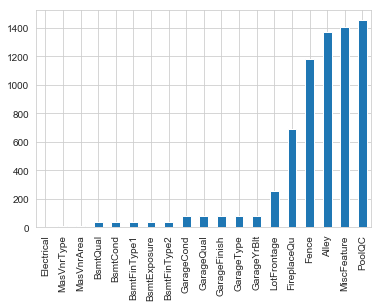

In [3]:
#quick way to see what data is missing 
#remember I dropped the pool stuff and utilities earlier as they had no variation

sns.set_style("whitegrid")
missing = df_train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

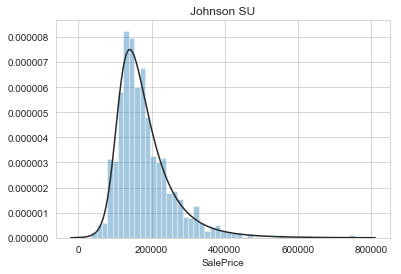

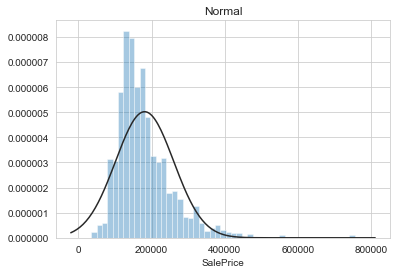

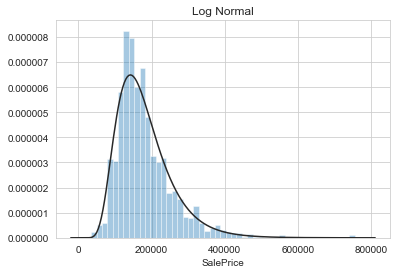

In [4]:
#distplot stands for distribution plot (so we can see how the data for SalePrice is distributed)
y = df_train['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

In [5]:
#the above plots show that the sale price is not normally distributed, so needs to be normalised
#they show also that the johnson SU distribution works best for this

#Also, now test the quantitative values to see if they are normally distributed
#stats.shapiro is a hypothesis test for the normal distribution, outputs a pair of variables
#the second variable [1], in the list, is the p-value...so a hypothesis test at the 5% sig level (original at 1%)
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.05
normal = pd.DataFrame(df_train[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())
#so none of the quantitiative variables are normally distrubted at a 1% significance level

#just to be clear, the sale price has not yet been normalised

False


In [6]:
#Spearman correlation is better to work with in this case because 
#it picks up relationships between variables even when they are nonlinear

"""I think the broad idea with this encode function is the same as makeOrdinal()"""
#create an empty df, 
#unique() then returns a numpy array of the unique values in the feature we're currently on
#make the index the actual sale price values (and discard the traditional 0,1,2,3,4 style deafult index)
#create another field on the df group them by the mean sale price
#sort the values
#create a new field called ordering, with a range to be the length of the df
#then convert the new field to a dictionary 
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(df_train, q)
    qual_encoded.append(q+'_E')

#qual_encoded is just a list of qualatative variables, now we have
#df and qual encoded ready to perform spearman correlation
print(qual_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


           feature  spearman
29   EnclosedPorch -0.218394
21    KitchenAbvGr -0.164826
4      OverallCond -0.129325
14    LowQualFinSF -0.067719
33         MiscVal -0.062727
9       BsmtFinSF2 -0.038806
35          YrSold -0.029899
17    BsmtHalfBath -0.012189
0       MSSubClass  0.007192
41     Utilities_E  0.016710
37        Street_E  0.045814
43     LandSlope_E  0.050310
32        PoolArea  0.058453
30       3SsnPorch  0.065440
34          MoSold  0.069432
61  BsmtFinType2_E  0.078553
50      RoofMatl_E  0.090497
31     ScreenPorch  0.100070
42     LotConfig_E  0.105029
46    Condition2_E  0.107173
62       Heating_E  0.121949
55     ExterCond_E  0.130370
67    Functional_E  0.136477
47      BldgType_E  0.151785
40   LandContour_E  0.154423
49     RoofStyle_E  0.163782
10       BsmtUnfSF  0.185197
72    GarageCond_E  0.193687
58      BsmtCond_E  0.196402
71    GarageQual_E  0.197412
..             ...       ...
7       MasVnrArea  0.421309
36      MSZoning_E  0.422232
52   Exterior2

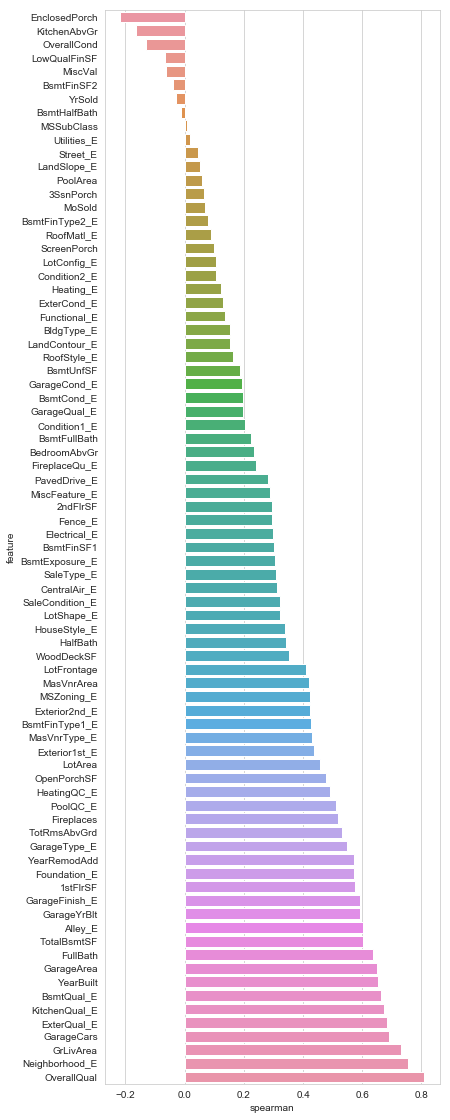

In [7]:
#create a new dataframe
#set a feature column with all the features
#set a spearman column which calculates the spearman for each feature passed in
#sort the results
#plot the results, then use seaborn to display it
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    print(spr)
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative + qual_encoded
spearman(df_train,features)

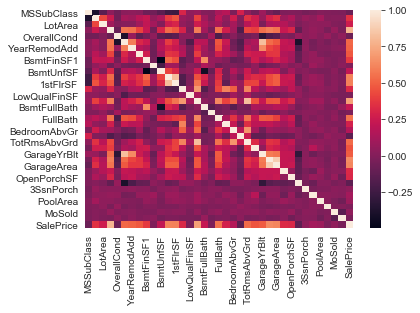

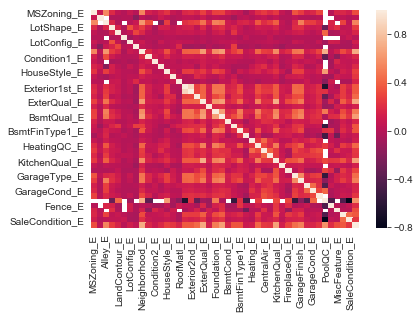

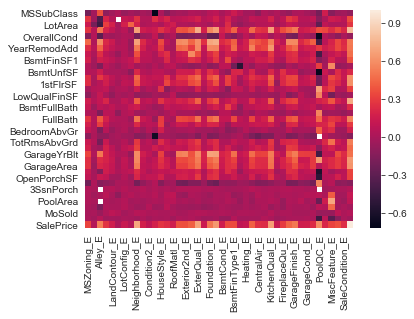

In [8]:
#declare a plot, then create the correlation, then pass it into seaborn
plt.figure(1)
corr = df_train[quantitative+['SalePrice']].corr()
sns.heatmap(corr)
plt.figure(2)
corr = df_train[qual_encoded+['SalePrice']].corr()
sns.heatmap(corr)

#this final correlation is the quantitative 'against' the qualitatitive encoded
plt.figure(3)
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]),\
                    index=quantitative+['SalePrice'], columns=qual_encoded+['SalePrice'])
for q1 in quantitative+['SalePrice']:
    for q2 in qual_encoded+['SalePrice']:
        corr.loc[q1, q2] = df_train[q1].corr(df_train[q2])
sns.heatmap(corr)

0.7532110033310244


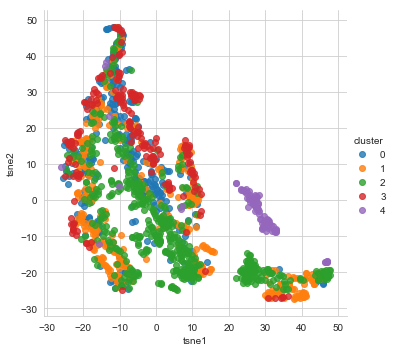

In [9]:
#TSNE t-distributed stochastic neighbour embedding
#in very loose terms, a means of feature reduction to view the data on a graph
#also makes use of PCA (principal component analysis)

features = quantitative + qual_encoded
model = TSNE(n_components=2, random_state=0, perplexity=50)
X = df_train[features].fillna(0.).values
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=30)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

,name,r-value,p-value
3,OverallQual,0.790982,2.185675e-313
15,GrLivArea,0.708624,4.518034e-223
44,Neighborhood_E,0.696882,9.711889e-213
54,ExterQual_E,0.682639,7.331707e-201
66,KitchenQual_E,0.659600,5.051357e-183
25,GarageCars,0.640409,2.498644e-169
26,GarageArea,0.623431,5.265038e-158
11,TotalBsmtSF,0.613581,9.484229e-152
12,1stFlrSF,0.605852,5.394711e-147
18,FullBath,0.560664,1.236470e-121


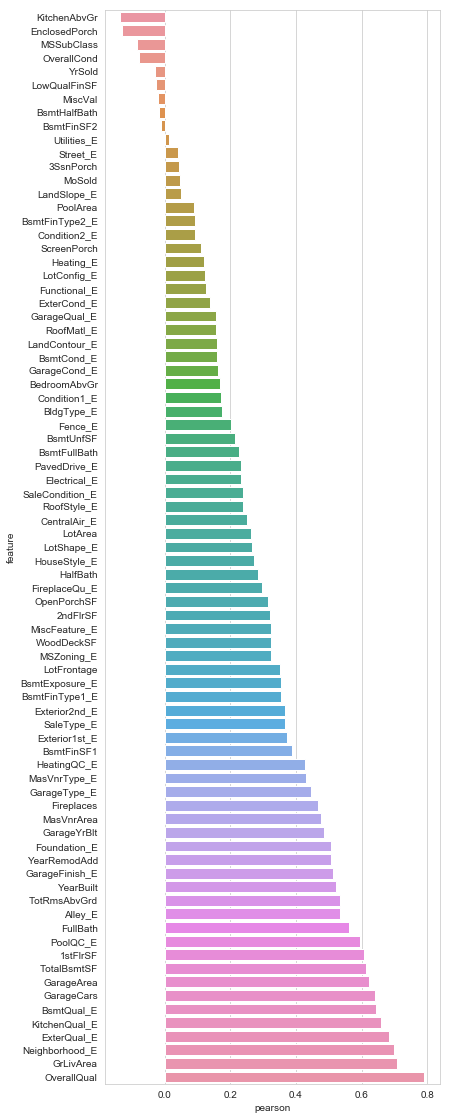

In [10]:
#Analysis only

#only select the int or float columns
#int_cols = [cname for cname in df_train.columns if df_train[cname].dtype in ['int64']]
#float_cols = [cname for cname in df_train.columns if df_train[cname].dtype in ['float64']]

def pearcorr(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['pearson'] = [frame[f].corr(frame['SalePrice'], 'pearson') for f in features]
    spr = spr.sort_values('pearson')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='pearson', orient='h')
    
features = quantitative + qual_encoded
pearcorr(df_train,features)

#here is another way and storing of values of pearsons correlation
sale_values = df_train['SalePrice']
prim_corr = pd.DataFrame(columns=['name', 'r-value', 'p-value'])

for idx,val in enumerate(features):
    p_reg = pearsonr(df_train[val],sale_values)
    prim_corr.loc[idx] = [val,*p_reg]

prim_corr = prim_corr.sort_values(by='r-value',ascending=False)
prim_corr

#taken out for now, linear regression...too expensive for now
#for idx,val in enumerate(features):
    #int_regression = linregress(df_train[val],sale_values)
    #prim_corr.loc[idx] = [val,int_regression.rvalue,int_regression.pvalue]

In [11]:
# Imputation
y = df_orig_train['SalePrice']
sale_predictors = df_orig_train.drop(['SalePrice'], axis=1)
#print(sale_predictors)

#only use the numerical features (when not excluding these, you will see the variation
#is spread over a greater number of Principal components, which is rubbish for us)
X = sale_predictors.select_dtypes(exclude=['object'])
#X = sale_predictors #test what happens if you don't exclude the categories
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=0)

my_imputer = SimpleImputer(strategy='mean')
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))

# Imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

#data has been split into train and validate variables, which is why there is now only 1168 rows
print(np.shape(imputed_X_train))

(1168, 37)


variance of data captured:  62.699999999999996


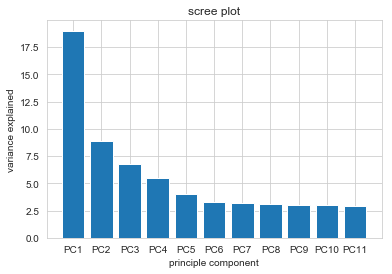

In [12]:
#this section assumes only numeric features are used, when all features are used it performs poorly
stdscale = StandardScaler()
scaled_imputed_X_train = stdscale.fit_transform(imputed_X_train)
pca = PCA(n_components=11)
pca_fin = pca.fit(scaled_imputed_X_train)
pca_fin = pca.transform(scaled_imputed_X_train)
per_var = np.round(pca.explained_variance_ratio_ * 100,decimals=1)
labelsp = ['PC' + str(x) for x in range(1,len(per_var)+1)]
print("variance of data captured: ",sum(per_var))
plt.bar(x=range(1,len(per_var)+1),height=per_var,tick_label=labelsp)
plt.xlabel("principle component")
plt.ylabel("variance explained")
plt.title("scree plot")
plt.show()

#further method to develop: loop to discover optimal acceptal number of PC's (60%) by itself

#the usual threshold might be 95% if we were being strict, but a minimum of 60% for it to be useable
#the lowest number of components I 've been able to reduce the dimensions down for the numerical values is 11
#after starting from 37...

In [13]:
#so we have seen:
#which columns have data missing
#a rough way of seperating quantitative and qualitative
#a way to check if distribution is normal (SalePrice needs normalising but I didn't normalise it in this code yet)
#various correlation types (pearson, spearman, graphs etc)
#simple imputation and scaling
#Graphs showing variation percentage covered by PCA
#clustering making use of PCA

#next steps, I will show which features I will choose

        features     Score
3        LotArea  10114971
34       MiscVal   6253332
14      2ndFlrSF    464884
9     BsmtFinSF1    399985
10    BsmtFinSF2    368882
8     MasVnrArea    285740
11     BsmtUnfSF    274751
15  LowQualFinSF    244880
16     GrLivArea    196850
12   TotalBsmtSF    174706


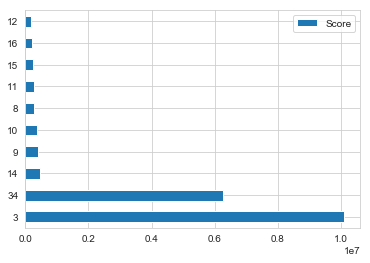

In [14]:
best_features = SelectKBest(score_func=chi2,k=10)

bf_imputer = SimpleImputer(strategy='mean')
bf_X = pd.DataFrame(my_imputer.fit_transform(X))

# Imputation removed column names; put them back
bf_X.columns = X.columns

fit = best_features.fit(bf_X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(bf_X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['features','Score']
#convert the scientific notation to integers which are easier to understand
featureScores['Score'] = featureScores['Score'].astype(int)
print(featureScores.nlargest(10,'Score'))
featureScores.nlargest(10,'Score').plot(kind='barh')

In [15]:
#lotArea and miscval have the highest scores, so I will try these first

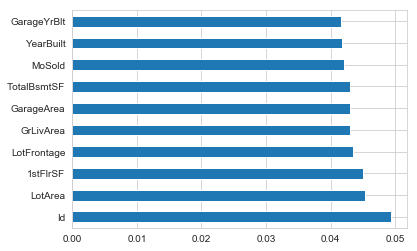

In [16]:
ExTreeClass = ExtraTreesClassifier(n_estimators=10)
ExTreeClass.fit(bf_X,y)
feature_importance = pd.Series(ExTreeClass.feature_importances_,index=bf_X.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.show()

In [60]:
#final_choices = ['LotArea','MiscVal','MoSold','LotFrontage','OverallQual','PoolQC_E',\
#'FullBath','GarageArea','YearBuilt','BsmtQual_E','KitchenQual_E',\
#'ExterQual_E','GarageCars','GrLivArea','Neighborhood_E','OverallQual','SalePrice']

#using the top 10 (positively) correlated features
final_choices = ['1stFlrSF','FullBath','GarageArea','YearBuilt','BsmtQual_E','KitchenQual_E',\
                 'ExterQual_E','GarageCars','GrLivArea','Neighborhood_E','OverallQual','SalePrice']

best_features = df_train[final_choices]

y = best_features['SalePrice']
sale_predictors = best_features.drop(['SalePrice'], axis=1)

#only use the numerical features (when not excluding these, you will see the variation
#is spread over a greater number of Principal components, which is rubbish for us)
X = sale_predictors.select_dtypes(exclude=['object'])
#X = sale_predictors #test what happens if you don't exclude the categories
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=0)

In [61]:
my_imputer = SimpleImputer(strategy='mean')
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))
# Imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

variance of data captured:  86.3


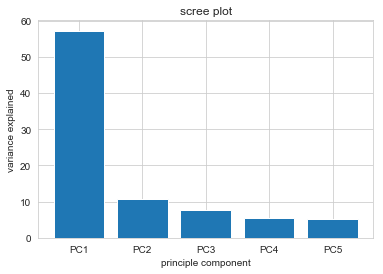

In [62]:
pca_components = 5
stdscale = StandardScaler()
scaled_imputed_X_train = stdscale.fit_transform(imputed_X_train)
pca = PCA(n_components=pca_components)
pca_fin = pca.fit(scaled_imputed_X_train)
pca_fin = pca.transform(scaled_imputed_X_train)
per_var = np.round(pca.explained_variance_ratio_ * 100,decimals=1)
labelsp = ['PC' + str(x) for x in range(1,len(per_var)+1)]

print("variance of data captured: ",sum(per_var))
plt.bar(x=range(1,len(per_var)+1),height=per_var,tick_label=labelsp)
plt.xlabel("principle component")
plt.ylabel("variance explained")
plt.title("scree plot")
plt.show()

scaled_imputed_X_valid = stdscale.fit_transform(imputed_X_valid)
pca = PCA(n_components=pca_components)
pca_fin_val = pca.fit(scaled_imputed_X_valid)
pca_fin_val = pca.transform(scaled_imputed_X_valid)

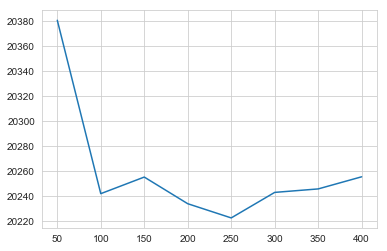

In [55]:
#Obtain optimal number of estimators to use for Random Forest model
def get_score(model):
    my_pipeline = Pipeline(steps=[('model', model)])
    
    scores = -1 * cross_val_score(my_pipeline, pca_fin, y_train,
                              cv=5,
                              scoring='neg_mean_absolute_error')
    return scores.mean()

results = {}
for idx,val in enumerate(range(50,450,50)):
    results[val] = get_score(RandomForestRegressor(n_estimators=val, random_state=0))

#the optimal number of estimators in this instance is 200
plt.plot(results.keys(), results.values())
plt.show()

In [63]:
print(np.shape(pca_fin))
linear_reg = LinearRegression()
linear_reg.fit(pca_fin,y_train)
lin_reg_pred = linear_reg.predict(pca_fin_val)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_valid, lin_reg_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_valid, lin_reg_pred))

#from sklearn.linear_model import LinearRegression
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.neighbors import KNeighborsRegressor
#from sklearn.ensemble import AdaBoostRegressor
#from sklearn.tree import DecisionTreeRegressor
#from xgboost import XGBRegressor

#using the linear regression as a benchmark to find optimal number of features for PCA
#this is my own work, not guided by anything else I have seen

(1168, 5)
Mean squared error: 1977724112.32
Variance score: 0.71


In [ ]:
"""models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)"""



In [ ]:
#regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
#                          n_estimators=300, random_state=rng)